In [ ]:
import os
import sys 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE 
import gc


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#mount from Google Drive 

try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  path = r'/content/drive/MyDrive/MIDS_w207_final_project'
except ModuleNotFoundError:
  path = r'data'


Mounted at /content/drive


In [ ]:
# notebook settings
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.4f}'.format


In [ ]:
# import datasets
df = pd.read_csv(os.path.join(path,'application_train.csv'))
bureau = pd.read_csv(os.path.join(path,'bureau.csv'))
prev_app = pd.read_csv(os.path.join(path,'previous_application.csv'))

#bureau_bal = pd.read_csv('bureau_balance.csv')

print("app_train data holds {} obs and {} variables".format(df.shape[0], df.shape[1]))
print("bureau data holds {} obs and {} variables".format(bureau.shape[0], bureau.shape[1]))
#print("bureau_bal data holds {} obs and {} variables".format(bureau_bal.shape[0], bureau_bal.shape[1]))
print("prev_app data holds {} obs and {} variables".format(prev_app.shape[0], prev_app.shape[1]))

app_train data holds 307511 obs and 122 variables
bureau data holds 1716428 obs and 17 variables
prev_app data holds 1670214 obs and 37 variables


# EDA

## Plotting Functions

In [ ]:
def multiplot_args(df, col_names, plots_across = 3):
    '''
    Determine subplot shape based on the number of features.
    '''
    
    n = len(col_names)
    total_cols = plots_across
    
    # determine the number of rows
    if n % total_cols > 0:
        total_rows = n // total_cols  + 1
    else: 
        total_rows = n // total_cols
    total_rows
    

    leftmargin = 0.4 #inches
    rightmargin = 0.5 #inches
    categorysize = 0.2 # inches   
    fig_width =  16 + leftmargin + rightmargin #+ (total_cols+1)
    fig_height = total_rows*4 # 4 inches for each row
    
    return total_rows, total_cols, fig_width, fig_height
    

In [ ]:
def categorical_feature_plots(df, cols):

    '''plot categorical features using Seaborn countplot'''
    
    total_rows, total_cols, fig_width, fig_height = multiplot_args(df, cols)
    
    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(fig_width, fig_height)) 
       
    for i, var in enumerate(cols):
        row = i// total_cols
        pos = i % total_cols
        
        # can only use row indexing if there is more than 1 row
        if total_rows == 1:
             sns.countplot(data = df, 
                     x = var,
                     ax = axs[pos])
        else:
            sns.countplot(data = df, 
                         x = var,
                         ax = axs[row][pos])

In [ ]:
def num_feature_plots(df, cols):
  
    '''plot categorical features'''
    
    total_rows, total_cols, fig_width, fig_height = multiplot_args(df, cols)

  
    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(fig_width, fig_height)) 

    for i, var in enumerate(cols):
        row = i// total_cols
        pos = i % total_cols
        # create an array to more easily remove NANs
        var_w_nans = df[var]
        axs[row][pos].hist(var_w_nans[~np.isnan(var_w_nans)], bins = 100)
        axs[row][pos].title.set_text(var)

## Application (Main) data set

## Missing Data

In [ ]:
#total
print("Percent of data missing:", round(df.isnull().sum().sum()/len(df),2))

Percent of data missing: 29.76


In [ ]:
#top features
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending = False)

COMMONAREA_MEDI               69.8723
COMMONAREA_AVG                69.8723
COMMONAREA_MODE               69.8723
NONLIVINGAPARTMENTS_MODE      69.4330
NONLIVINGAPARTMENTS_MEDI      69.4330
                                ...  
REG_CITY_NOT_LIVE_CITY         0.0000
LIVE_REGION_NOT_WORK_REGION    0.0000
REG_REGION_NOT_WORK_REGION     0.0000
HOUR_APPR_PROCESS_START        0.0000
SK_ID_CURR                     0.0000
Length: 122, dtype: float64

### Integer Features

There are 41 numeric features


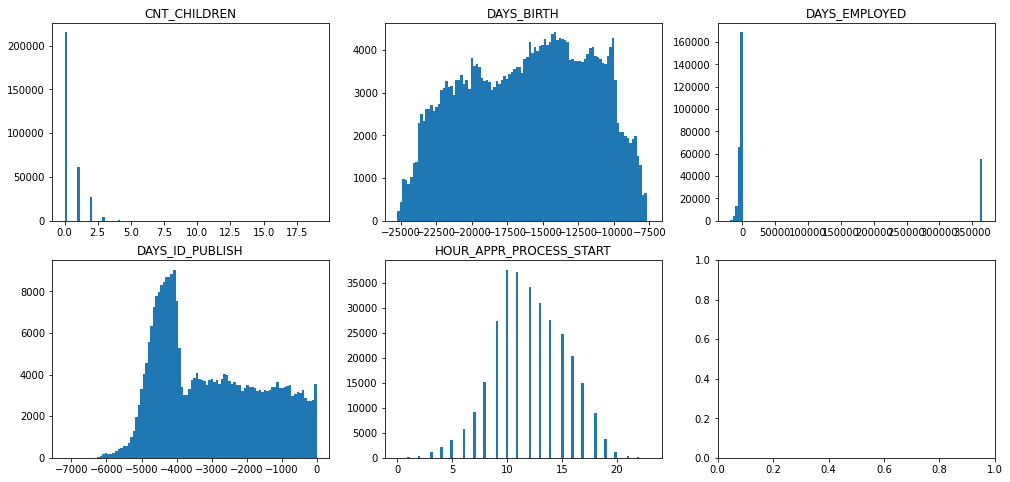

In [ ]:
integer_columns = df.select_dtypes(include=['int64']).columns 

print("There are %s numeric features"%(integer_columns.shape))

# split features based on whether they are BOOL but entered as 1,0

# remove the FLAG columns they're not helpful here as they're equivalent to BOOLEANS
does_not_start_with = ('FLAG', 'REGION', 'REG_CITY', 'REG_REGION', 'LIVE_REGION', 'LIVE_CITY')

# save out the columns that are treated like BOOLs
bool_as_int_columns = [x for x in integer_columns if x.startswith(does_not_start_with)]
integer_columns = [x for x in integer_columns if not x.startswith(does_not_start_with)]

# also remove TARGET and ID 
others_to_remove = ['TARGET', 'SK_ID_CURR']
integer_columns = [i for i in integer_columns if i not in others_to_remove]
integer_columns

# visualize remaining integer columns and print the description of the data
df[integer_columns].describe().T
num_feature_plots(df, integer_columns)

In [ ]:
# remove observations with anomalous data
df['DAYS_EMPLOYED_ANOM'] = df['DAYS_EMPLOYED'] == 365243
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace({365243: np.nan})
df['DAYS_EMPLOYED_ANOM'] = df['DAYS_EMPLOYED_ANOM'].astype(int)

# now check the max
print("max days employed: ", df.DAYS_EMPLOYED.max())

max days employed:  0


In [ ]:
def corr_heatmap(selected_columns):
    '''Correlation heatmap with specific columns vs TARGET'''
    corr_col_list = copy.deepcopy(selected_columns)
    corr_col_list.insert(0,'TARGET')

    cm = np.corrcoef(df[corr_col_list].values.T)
    
    # set figsize dynamically
    f_size = len(selected_columns)

    f, ax = plt.subplots(figsize =(f_size, f_size)) 

    sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
        linewidths = 0.1, yticklabels = corr_col_list,  
                          xticklabels = corr_col_list) 

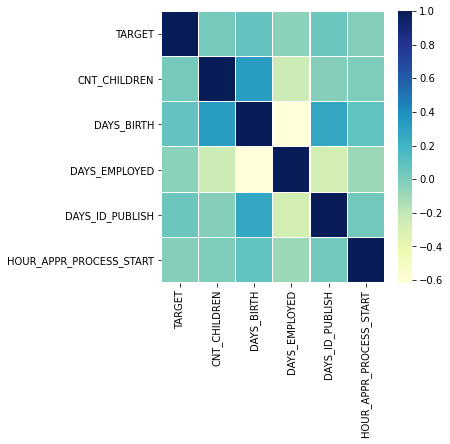

In [ ]:
# run a correlation
corr_heatmap(integer_columns)


Children (```CNT_CHILDREN```) and Age (```DAYS_BIRTH```) are the most correlated with ```TARGET```. But, the majority of features have moderate or low correlation with ```TARGET``` and each other. 

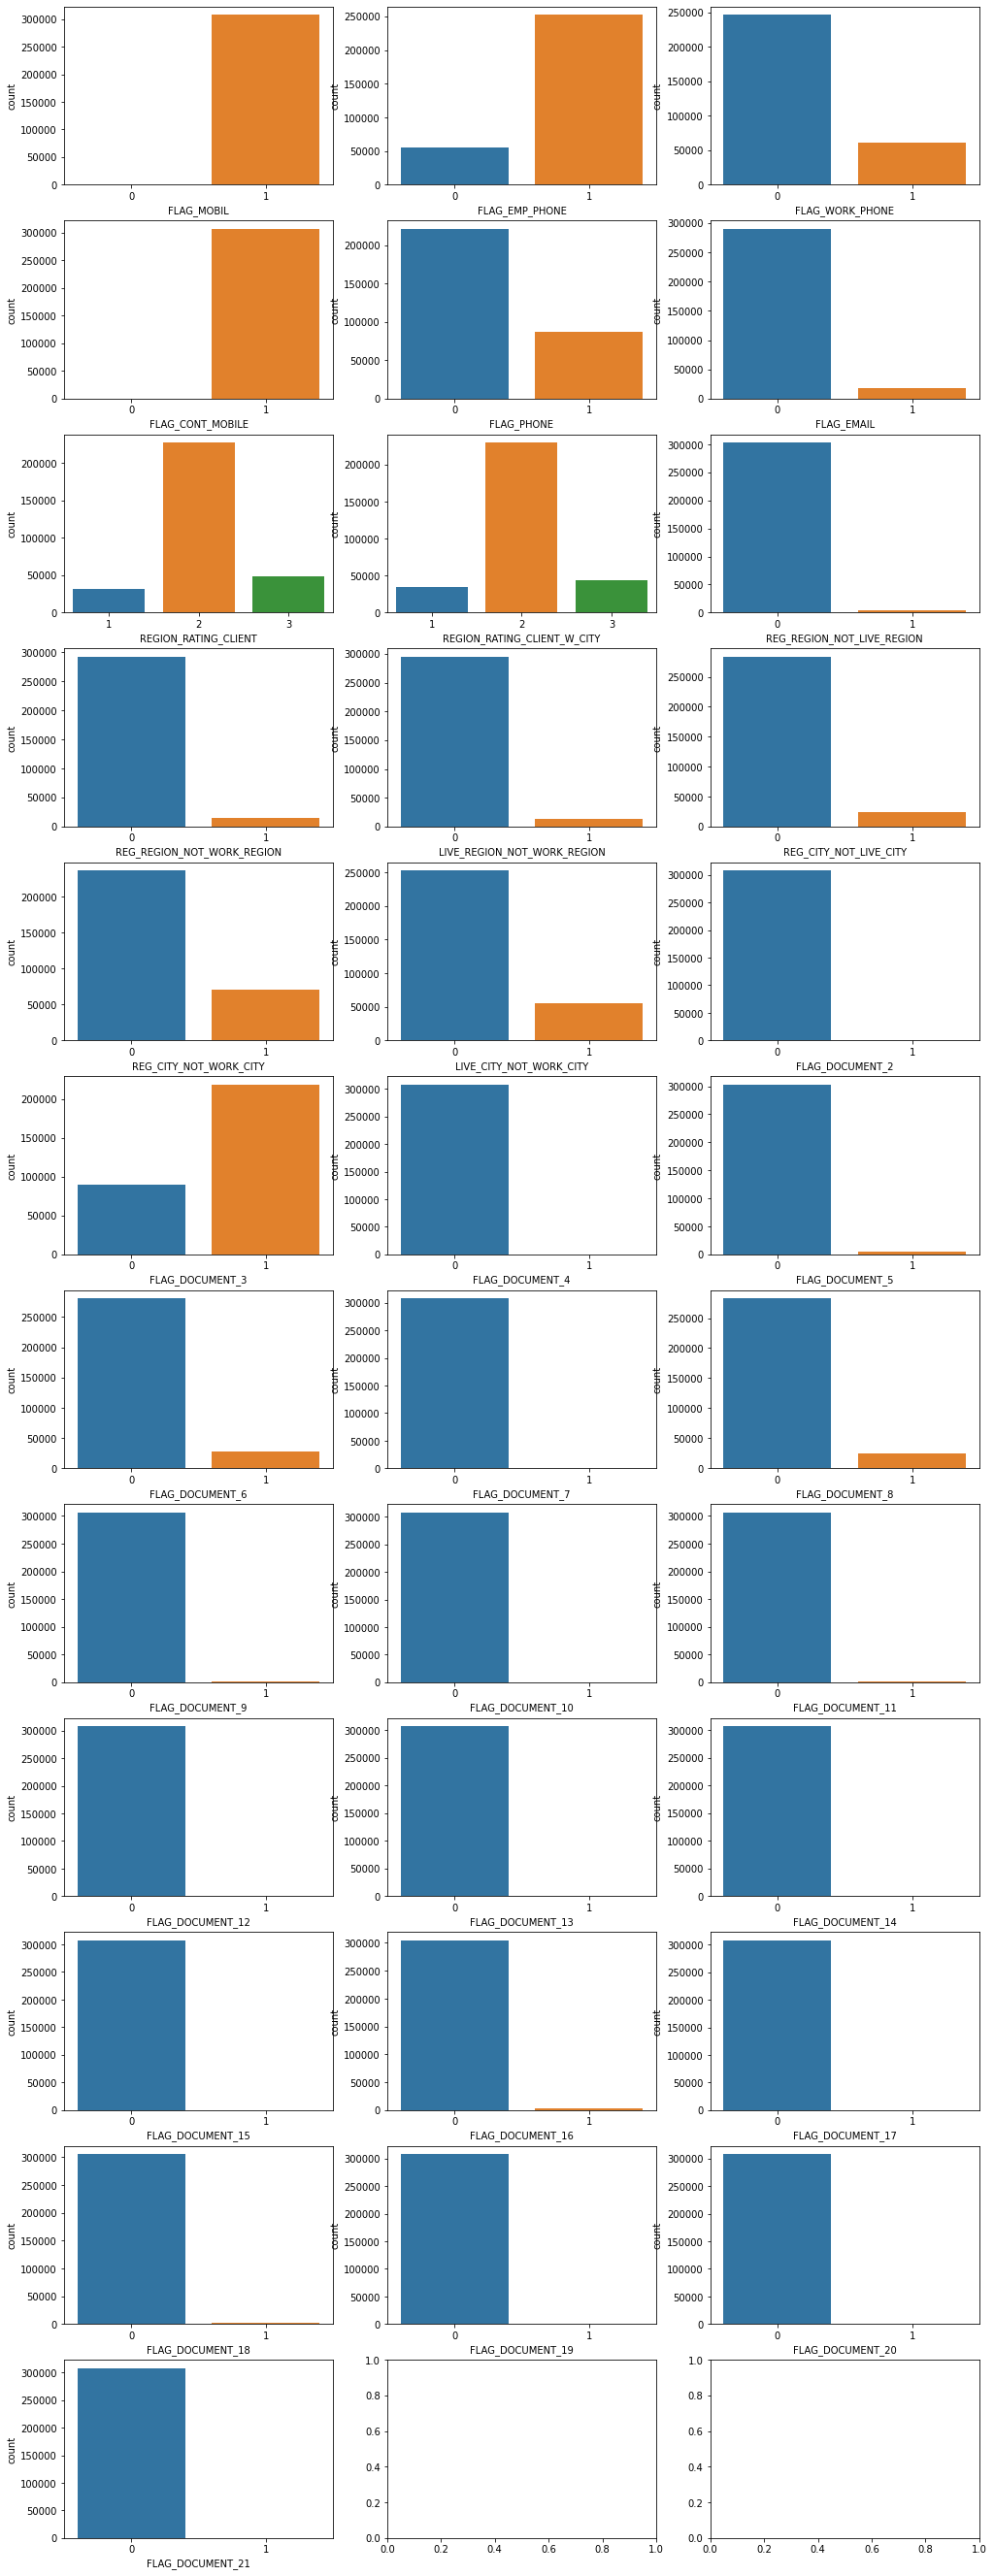

In [ ]:
# now combine check out the BOOL features removed above for visualization
categorical_feature_plots(df,bool_as_int_columns)


Nothing too interesting to note here. 

### Float features

In [ ]:
float_columns = df.select_dtypes(include=['float64']).columns 

print("There are %s float features"%(float_columns.shape))
print(float_columns)
df[float_columns].describe()

There are 65 float features
Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMON

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,252137.0000,252137.0000,252125.0000,251881.0000,252137.0000,252137.0000,94413.0000,252135.0000,121276.0000,251633.0000,...,251288.0000,251288.0000,251288.0000,252136.0000,218281.0000,218281.0000,218281.0000,218281.0000,218281.0000,218281.0000
mean,175914.0708,611398.4576,27812.3252,549405.6682,0.0209,-4635.4308,11.9502,2.2525,0.4819,0.5161,...,0.1399,1.3987,0.0977,-971.0386,0.0066,0.0070,0.0341,0.2820,0.2598,1.8563
std,258851.5877,406527.1999,14647.7591,373268.5346,0.0139,3252.1692,11.9820,0.9421,0.2055,0.1899,...,0.4419,2.3785,0.3581,827.3053,0.0851,0.1110,0.2028,0.9484,0.8237,1.8263
min,25650.0000,45000.0000,1980.0000,40500.0000,0.0003,-22928.0000,0.0000,1.0000,0.0146,0.0000,...,0.0000,0.0000,0.0000,-4292.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,112500.0000,277969.5000,17073.0000,247500.0000,0.0100,-6952.0000,5.0000,2.0000,0.3190,0.3983,...,0.0000,0.0000,0.0000,-1578.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,157500.0000,521280.0000,25834.5000,450000.0000,0.0188,-4265.0000,9.0000,2.0000,0.4809,0.5671,...,0.0000,0.0000,0.0000,-763.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,211500.0000,829224.0000,35617.5000,693000.0000,0.0287,-1845.0000,15.0000,3.0000,0.6450,0.6639,...,0.0000,2.0000,0.0000,-288.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
max,117000000.0000,4050000.0000,258025.5000,4050000.0000,0.0725,0.0000,91.0000,20.0000,0.9444,0.8550,...,34.0000,344.0000,24.0000,0.0000,4.0000,9.0000,8.0000,27.0000,261.0000,23.0000


Bureau-related features:  6
Remaining float features:  59


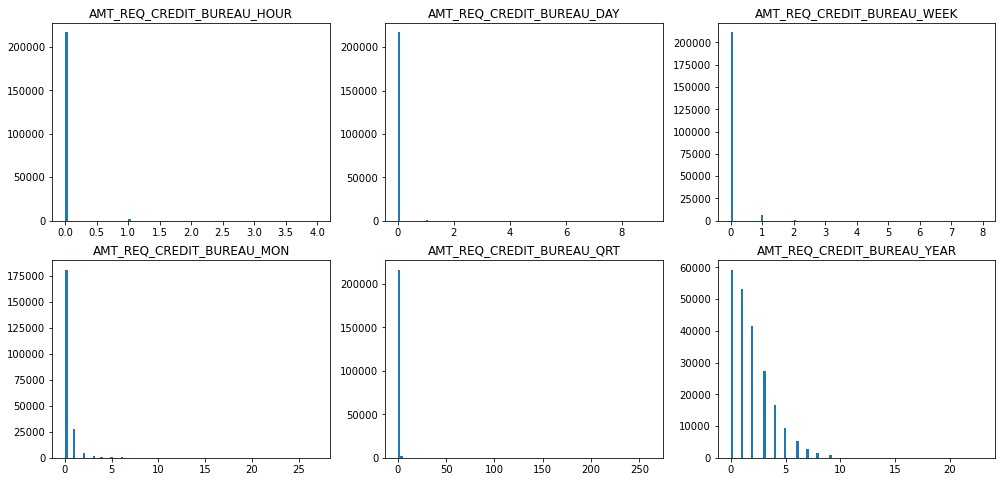

In [ ]:
# split up the features a bit to make visual review easier
# look at the Bureau-related features and EXT_SOURCE separately
bureau_related = [x for x in float_columns if x.startswith('AMT_REQ')]
remaining_float = [i for i in float_columns if i not in bureau_related]

print("Bureau-related features: ", len(bureau_related))
print("Remaining float features: ", len(remaining_float))

num_feature_plots(df, bureau_related)

looks like the ```AMT_REQ_CREDIT_BUREAU_YEAR``` has the most variance. If the the others are sparse, consider removing

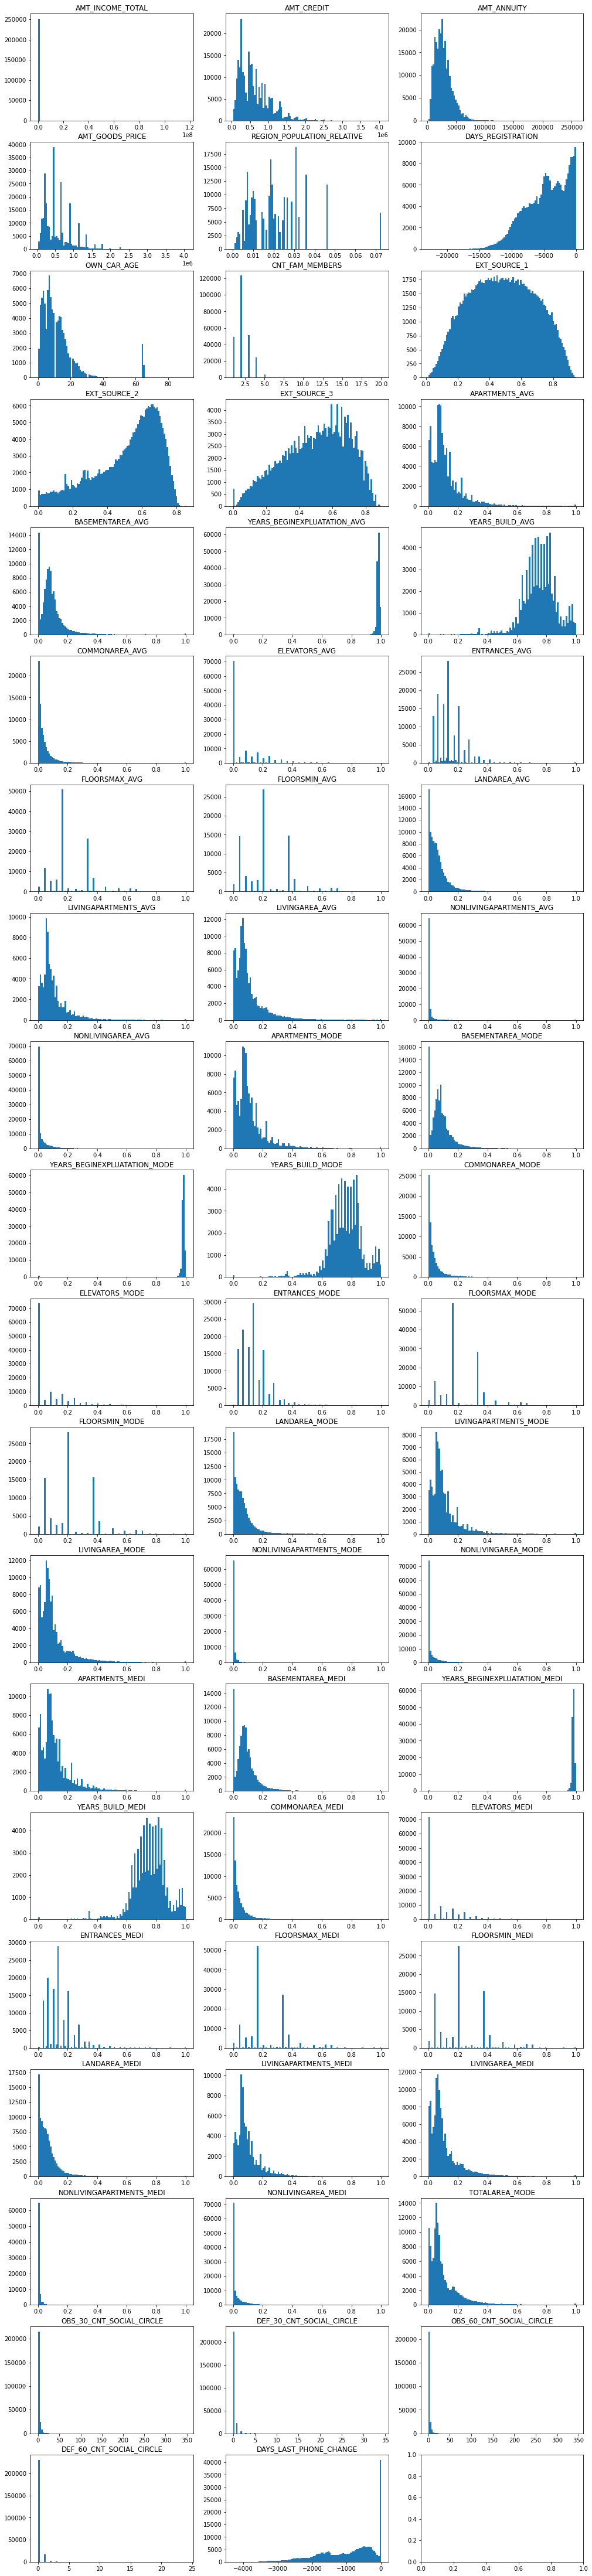

In [ ]:
num_feature_plots(df, remaining_float)

<AxesSubplot:>

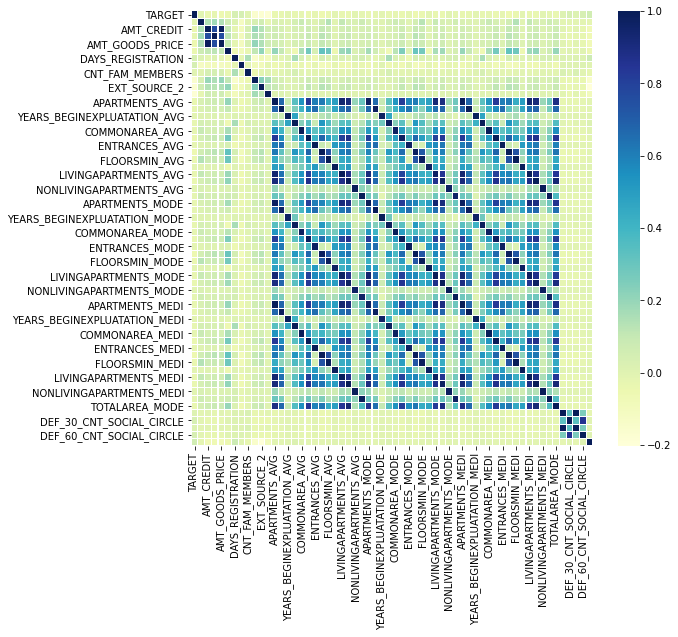

In [ ]:
corr_col_list = copy.deepcopy(remaining_float)
corr_col_list.insert(0,'TARGET')

df_corr = df[corr_col_list].corr()
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(df_corr, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

There are correlations amongst variables, particularly those describing the real estate asset. There are also some with ```AMT_GOODS_PRICE```. 

### Categorical features

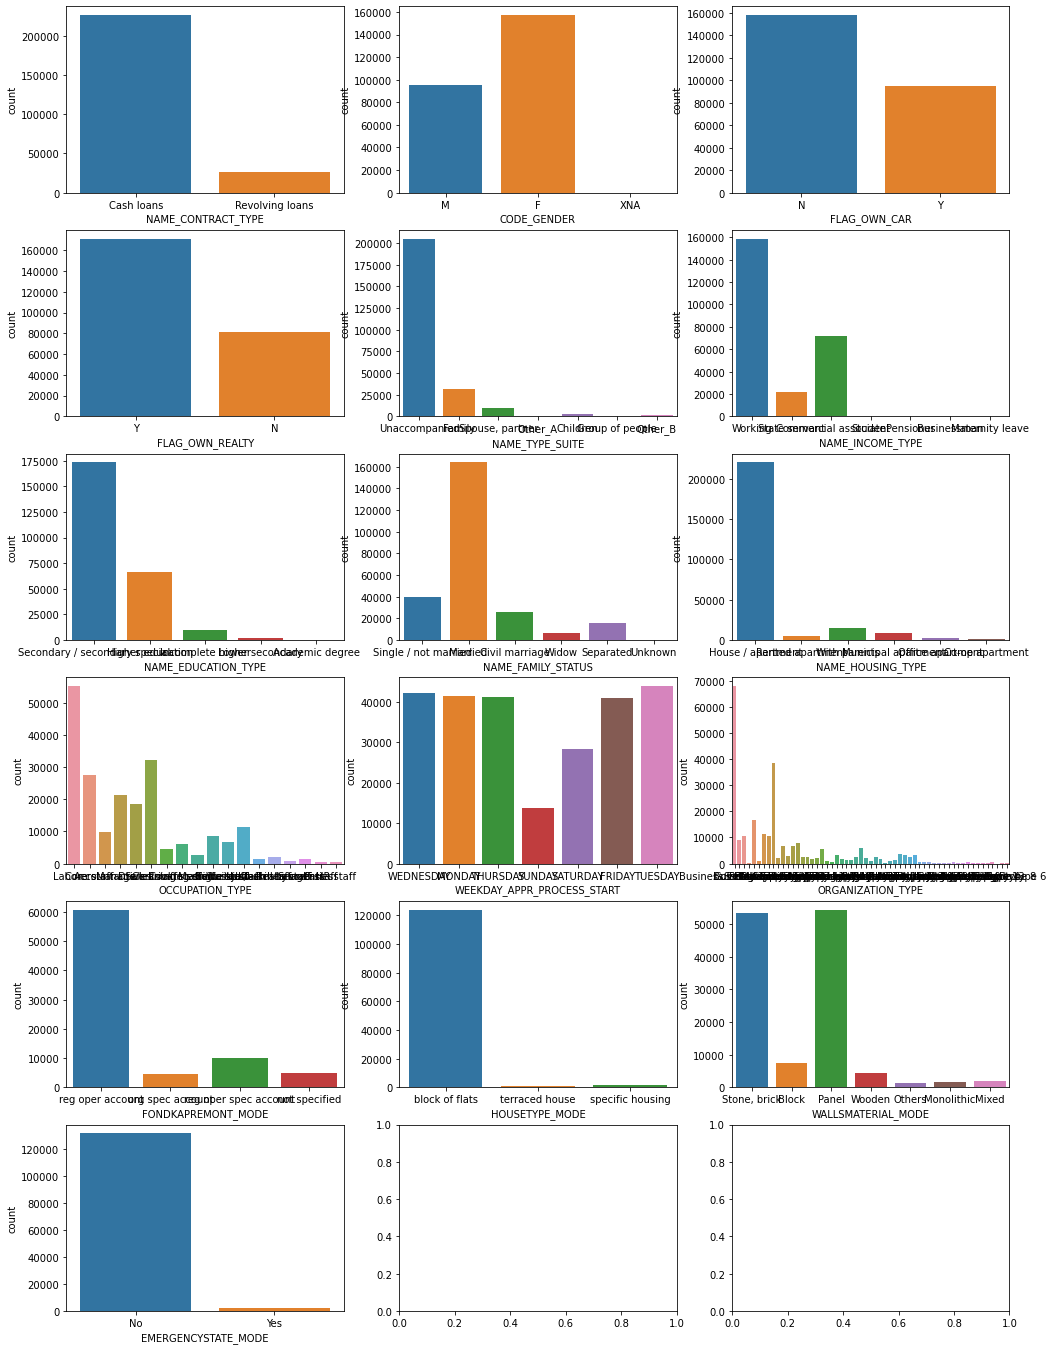

In [ ]:
cat_columns = df.select_dtypes(include=['object', 'category']).columns 
categorical_feature_plots(df,cat_columns)

In [ ]:
# look at categorical variables with the greatest number of unique levels
df[cat_columns].describe().T.sort_values(by='unique', ascending=False)


,count,unique,top,freq
ORGANIZATION_TYPE,252137,57,Business Entity Type 3,67992
OCCUPATION_TYPE,211118,18,Laborers,55186
NAME_TYPE_SUITE,251041,7,Unaccompanied,205018
NAME_INCOME_TYPE,252137,7,Working,158774
WEEKDAY_APPR_PROCESS_START,252137,7,TUESDAY,43948
WALLSMATERIAL_MODE,124530,7,Panel,54339
NAME_FAMILY_STATUS,252137,6,Married,163914
NAME_HOUSING_TYPE,252137,6,House / apartment,220483
NAME_EDUCATION_TYPE,252137,5,Secondary / secondary special,173286
FONDKAPREMONT_MODE,80055,4,reg oper account,60737


Looks like ```ORGANIZATION_TYPE``` has a large number of levels and lots of missing data. May be a good candidate for removing.

## Bureau Data


In [ ]:
bureau_int_features = bureau.iloc[:, 2:].select_dtypes('int64').columns.values
bureau_float_features = bureau.iloc[:, 2:].select_dtypes('float64').columns.values
bureau_cat_features = bureau.select_dtypes(include=['object', 'category']).columns

print('# of integer features:', len(bureau_int_features))
print('# of float features:', len(bureau_float_features))
print('# of str features:', len(bureau_cat_features))

# of integer features: 4
# of float features: 8
# of str features: 3


In [ ]:
bureau.iloc[:,2:].describe().T

,count,mean,std,min,25%,50%,75%,max
DAYS_CREDIT,1716428.0000,-1142.1077,795.1649,-2922.0000,-1666.0000,-987.0000,-474.0000,0.0000
CREDIT_DAY_OVERDUE,1716428.0000,0.8182,36.5444,0.0000,0.0000,0.0000,0.0000,2792.0000
DAYS_CREDIT_ENDDATE,1610875.0000,510.5174,4994.2198,-42060.0000,-1138.0000,-330.0000,474.0000,31199.0000
DAYS_ENDDATE_FACT,1082775.0000,-1017.4371,714.0106,-42023.0000,-1489.0000,-897.0000,-425.0000,0.0000
AMT_CREDIT_MAX_OVERDUE,591940.0000,3825.4177,206031.6062,0.0000,0.0000,0.0000,0.0000,115987185.0000
CNT_CREDIT_PROLONG,1716428.0000,0.0064,0.0962,0.0000,0.0000,0.0000,0.0000,9.0000
AMT_CREDIT_SUM,1716415.0000,354994.5919,1149811.3440,0.0000,51300.0000,125518.5000,315000.0000,585000000.0000
AMT_CREDIT_SUM_DEBT,1458759.0000,137085.1200,677401.1310,-4705600.3200,0.0000,0.0000,40153.5000,170100000.0000
AMT_CREDIT_SUM_LIMIT,1124648.0000,6229.5150,45032.0315,-586406.1150,0.0000,0.0000,0.0000,4705600.3200
AMT_CREDIT_SUM_OVERDUE,1716428.0000,37.9128,5937.6500,0.0000,0.0000,0.0000,0.0000,3756681.0000


Notes for feature engineering:
* Active and bad debt will be useful flag for feature engineering later. 
* Remove negative values ```DAYS_CREDIT_ENDDATE``` because we don't need duration of **inactive loans** and we already have ```DAYS_ENDDATE_FACT``` for closed loans.
* Remove negative amounts for all of these AMT data. 

### Numeric Features

In [ ]:
import warnings
warnings.filterwarnings('ignore')
bureau['DAYS_CREDIT_ENDDATE'][bureau['DAYS_CREDIT_ENDDATE'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_OVERDUE'][bureau['AMT_CREDIT_SUM_OVERDUE'] < 0] = np.nan
bureau['AMT_ANNUITY'][bureau['AMT_ANNUITY'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_LIMIT'][bureau['AMT_CREDIT_SUM_LIMIT'] < 0] = np.nan
bureau['AMT_CREDIT_SUM_DEBT'][bureau['AMT_CREDIT_SUM_DEBT'] < 0] = np.nan
bureau['AMT_CREDIT_SUM'][bureau['AMT_CREDIT_SUM'] < 0] = np.nan
bureau['AMT_CREDIT_MAX_OVERDUE'][bureau['AMT_CREDIT_MAX_OVERDUE'] < 0] = np.nan
print(bureau.iloc[:, 2:].select_dtypes('float64').describe())

       DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
count          603486.0000       1082775.0000             591940.0000   
mean             3106.7260         -1017.4371               3825.4177   
std              7384.7634           714.0106             206031.6062   
min                 0.0000        -42023.0000                  0.0000   
25%               323.0000         -1489.0000                  0.0000   
50%               790.0000          -897.0000                  0.0000   
75%              1386.0000          -425.0000                  0.0000   
max             31199.0000             0.0000          115987185.0000   

       AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
count    1716415.0000         1450341.0000          1124297.0000   
mean      354994.5919          137926.1187             6238.8775   
std      1149811.3440          679233.8310            45022.3336   
min            0.0000               0.0000                0.0000   
25

Feature Engineering Notes (cont'd): 
* Remove positive values for DAYS_CREDIT_UPDATE they  don't make sense in our context. 

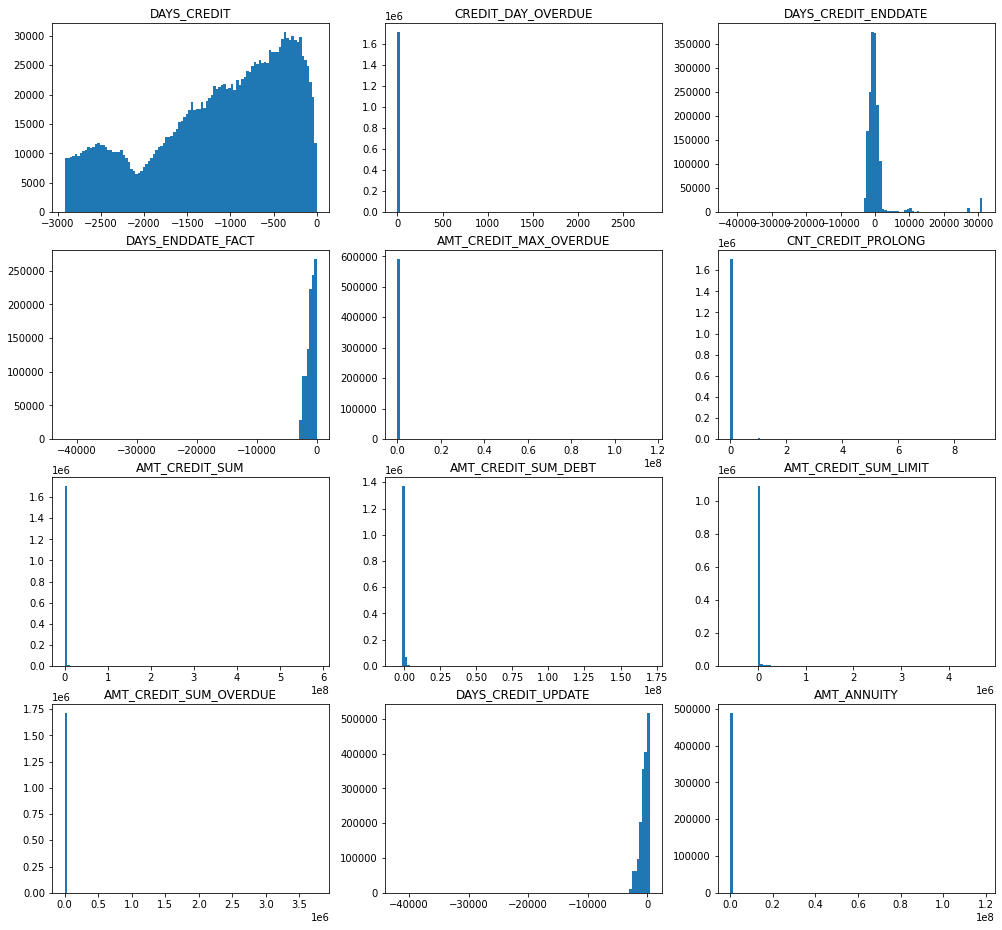

In [ ]:
bureau_num_features = bureau.iloc[:, 2:].select_dtypes(include=['int64', 'float64']).columns

num_feature_plots(bureau, bureau_num_features)

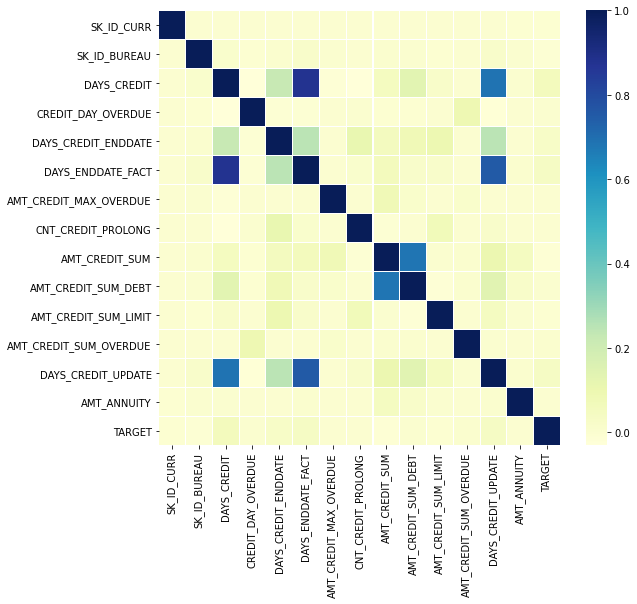

In [ ]:
# Correlations
bureau_with_target = bureau.merge(df[['TARGET','SK_ID_CURR']], on = ['SK_ID_CURR'], how = 'left')
bureau_with_target_num_features = bureau_with_target.select_dtypes(include=['int64', 'float64']).columns

bureau_corr = bureau_with_target[bureau_with_target_num_features].corr()
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(bureau_corr, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

### Categorical Features

Credit Type unique elements:  15


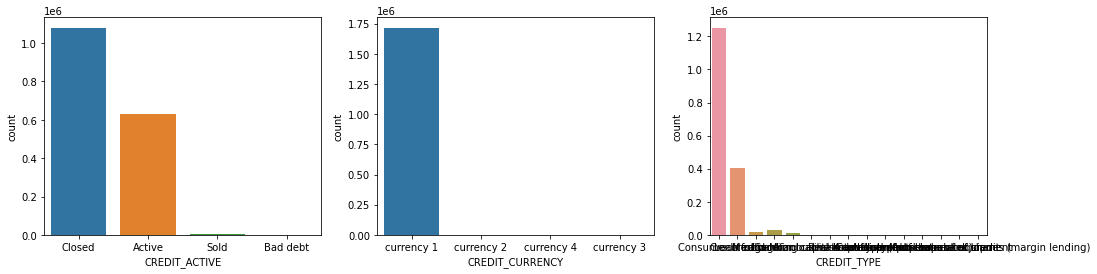

In [ ]:
categorical_feature_plots(bureau,bureau_cat_features)

print("Credit Type unique elements: ", bureau.CREDIT_TYPE.nunique())

## Previous Applicaton Data

In [ ]:
int_features = prev_app.iloc[:, 2:].select_dtypes('int64').columns.values
float_features = prev_app.iloc[:, 2:].select_dtypes('float64').columns.values
str_features = prev_app.iloc[:, 2:].select_dtypes('O').columns.values

print('# of integer features:', len(int_features))
print('# of float features:', len(float_features))
print('# of str features:', len(str_features))

print("\n\n%3.0f of applicants previously applied. Of these,"
      "%3.0f percent had more than one prior application."
      %(prev_app.SK_ID_CURR.nunique(),\
        (prev_app.SK_ID_CURR.nunique()/prev_app.SK_ID_CURR.count())*100))

# of integer features: 0
# of float features: 19
# of str features: 16


338857 of applicants previously applied. Of these, 20 percent had more than one prior application.


Approved, Refused, High/Low Interest and New and Repeat will be interesting flag to use for feature engineering later

In [ ]:
prev_app.iloc[:, 2:].describe().T

,count,mean,std,min,25%,50%,75%,max
AMT_ANNUITY,1297979.0000,15955.1207,14782.1373,0.0000,6321.7800,11250.0000,20658.4200,418058.1450
AMT_APPLICATION,1670214.0000,175233.8604,292779.7624,0.0000,18720.0000,71046.0000,180360.0000,6905160.0000
AMT_CREDIT,1670213.0000,196114.0212,318574.6165,0.0000,24160.5000,80541.0000,216418.5000,6905160.0000
AMT_DOWN_PAYMENT,774370.0000,6697.4021,20921.4954,-0.9000,0.0000,1638.0000,7740.0000,3060045.0000
AMT_GOODS_PRICE,1284699.0000,227847.2793,315396.5579,0.0000,50841.0000,112320.0000,234000.0000,6905160.0000
HOUR_APPR_PROCESS_START,1670214.0000,12.4842,3.3340,0.0000,10.0000,12.0000,15.0000,23.0000
NFLAG_LAST_APPL_IN_DAY,1670214.0000,0.9965,0.0593,0.0000,1.0000,1.0000,1.0000,1.0000
RATE_DOWN_PAYMENT,774370.0000,0.0796,0.1078,-0.0000,0.0000,0.0516,0.1089,1.0000
RATE_INTEREST_PRIMARY,5951.0000,0.1884,0.0877,0.0348,0.1607,0.1891,0.1933,1.0000
RATE_INTEREST_PRIVILEGED,5951.0000,0.7735,0.1009,0.3732,0.7156,0.8351,0.8525,1.0000


In [ ]:
#Sellerplace_area shouldn't be negative
#Amt_down_payment, shouldn't be negative. DAYS_ fields shouldn't be positive

prev_app[prev_app['SELLERPLACE_AREA'] < 0] = np.nan
prev_app[prev_app['AMT_DOWN_PAYMENT'] < 0] = np.nan
prev_app[prev_app['DAYS_FIRST_DRAWING'] > 0] = np.nan
prev_app[prev_app['DAYS_FIRST_DUE'] > 0] = np.nan
prev_app[prev_app['DAYS_LAST_DUE_1ST_VERSION'] > 0] = np.nan
prev_app[prev_app['DAYS_LAST_DUE'] > 0] = np.nan
prev_app[prev_app['DAYS_TERMINATION'] > 0] = np.nan

### Numeric Features

There are 19 float features
['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


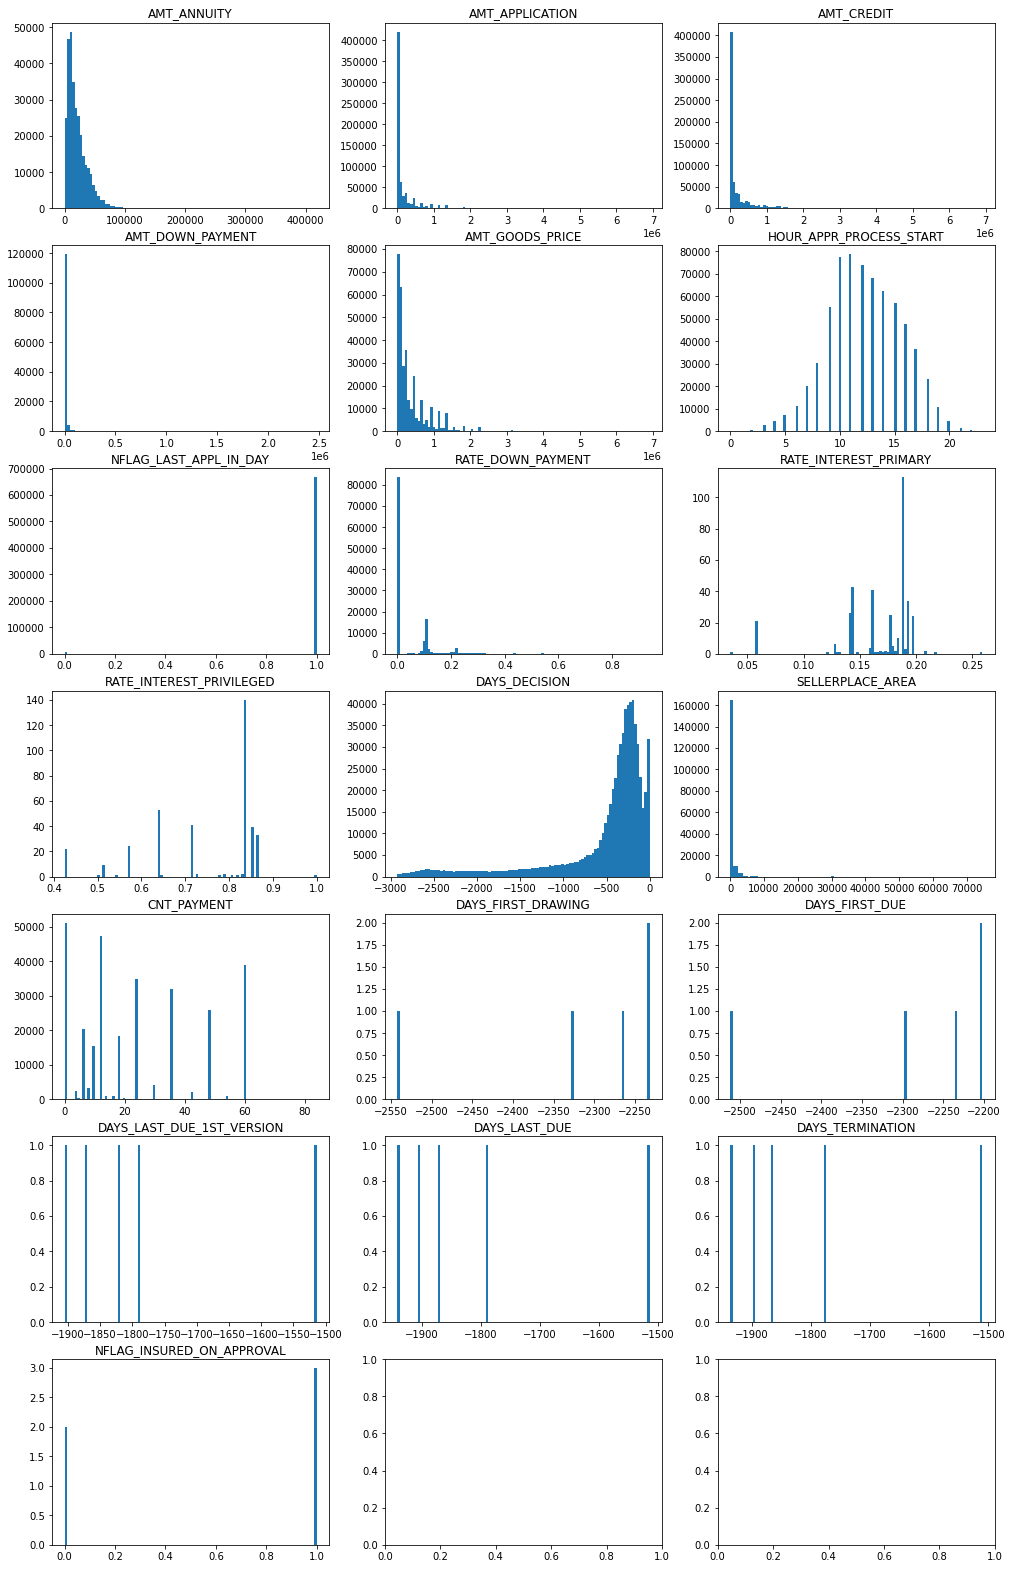

In [ ]:
num_columns = prev_app.select_dtypes(include=['float64','int64']).columns 
id_features = ['SK_ID_PREV', 'SK_ID_CURR']
num_columns = [i for i in num_columns if i not in id_features]

print("There are %s float features"%(len(num_columns)))
print(num_columns)

num_feature_plots(prev_app, num_columns)

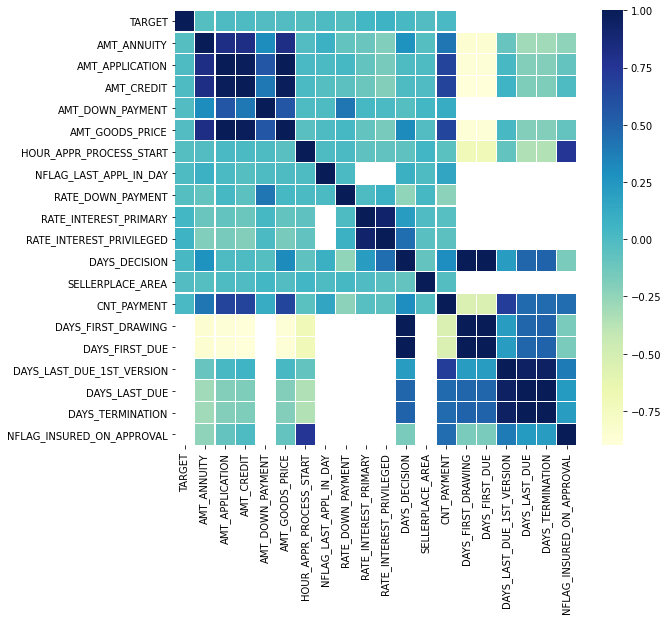

In [ ]:
# Correlations
prev_app_with_target = prev_app.merge(df[['TARGET','SK_ID_CURR']], on = ['SK_ID_CURR'], how = 'left')

# add TARGET to list for corr heat map
num_columns.insert(0,'TARGET')

# viusalize
prev_app_corr = prev_app_with_target[num_columns].corr()
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(prev_app_corr, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

Correlations with TARGET are weak. There are strong correlations among the previous application data, which makes intuitive sense.

### Categorial Features

There are 16 float features
Index(['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')


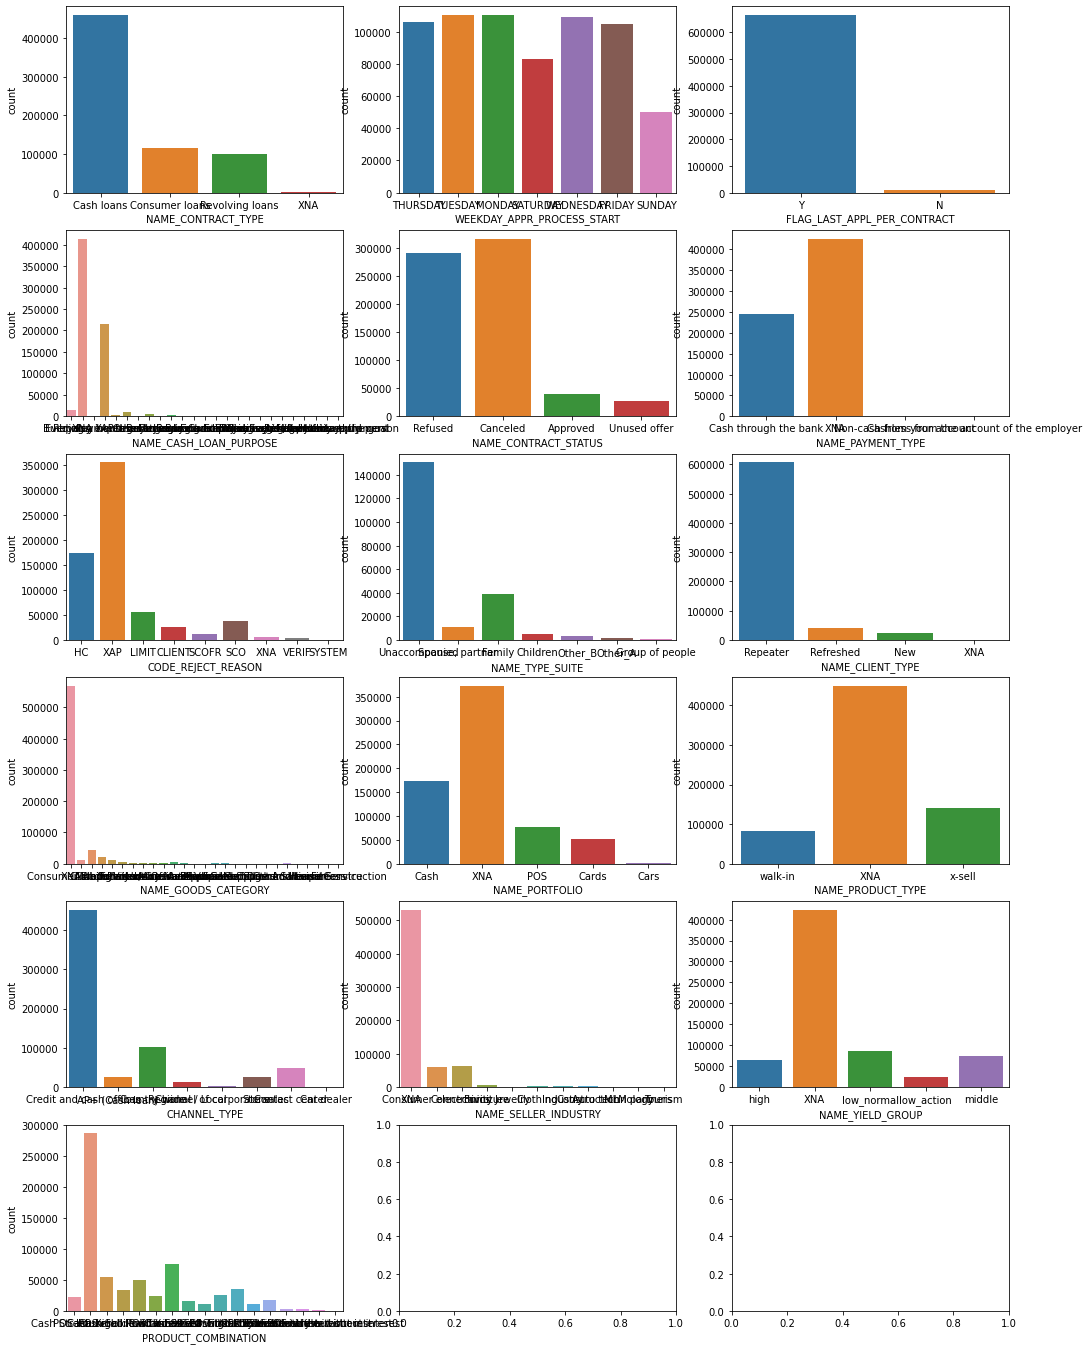

In [ ]:
prev_cat_columns = prev_app.select_dtypes(include=['object', 'category']).columns 

print("There are %s float features"%(len(prev_cat_columns)))
print(prev_cat_columns)

categorical_feature_plots(prev_app, prev_cat_columns)

There are several categories with many elements. Once we one-hot code them it'll expand our param count substantially.

In [ ]:
print("-" * 80)
print("{:30} | {:10}".format("Feature", "N-unique Elements"))
print("-" * 80)

for i in prev_cat_columns:
   print("{:30} | {:10}".format(i,prev_app[i].nunique()))


--------------------------------------------------------------------------------
Feature                        | N-unique Elements
--------------------------------------------------------------------------------
NAME_CONTRACT_TYPE             |          4
WEEKDAY_APPR_PROCESS_START     |          7
FLAG_LAST_APPL_PER_CONTRACT    |          2
NAME_CASH_LOAN_PURPOSE         |         25
NAME_CONTRACT_STATUS           |          4
NAME_PAYMENT_TYPE              |          4
CODE_REJECT_REASON             |          9
NAME_TYPE_SUITE                |          7
NAME_CLIENT_TYPE               |          4
NAME_GOODS_CATEGORY            |         27
NAME_PORTFOLIO                 |          5
NAME_PRODUCT_TYPE              |          3
CHANNEL_TYPE                   |          8
NAME_SELLER_INDUSTRY           |         11
NAME_YIELD_GROUP               |          5
PRODUCT_COMBINATION            |         17
